In [1]:
import hmc_tomography
import numpy
import matplotlib.pyplot as plt
import psvWave
from matplotlib import animation
from scipy.optimize import minimize

/home/larsgebraad/Documents/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Distributions/__init__.py:43: UserWarning: Couldn't find the required package for LASIF. Detailed error message: No module named 'hmc_tomography.Distributions.LasifFWI'
  f"Couldn't find the required package for LASIF. Detailed error message: {e}"


# Entry point 1: Create observations

## Create FD model from domain and inspect source receiver setup

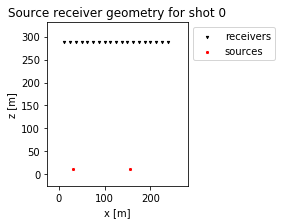

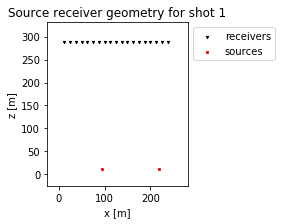

In [2]:
fd_model = psvWave.fdModel("conf_10k.ini")

# m2 = fd_model._copy()

for i in range(fd_model.n_shots):
    axis = fd_model.plot_domain(shot_to_plot=i)
    axis.set_title(f"Source receiver geometry for shot {i}")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

In [3]:
fd_model

## Create reference solution without anomalies

In [4]:
for i_shot in range(fd_model.n_shots):
    fd_model.forward_simulate(i_shot, omp_threads_override=6)

ux_ref, uz_ref = fd_model.get_synthetic_data()

## Create target model

In [5]:
# Get the coordinates of every grid point
IX, IZ = fd_model.get_coordinates(True)
extent = fd_model.get_extent(True)
# Get the associated parameter fields
vp, vs, rho = fd_model.get_parameter_fields()

vp_starting = vp
vs_starting = vs
rho_starting = rho

# Circle 1
anomaly = -0.1
radius = 25
x_middle = 124.9
z_middle = 149.88
circle = ((IX - x_middle) ** 2 + (IZ - z_middle) ** 2) ** 0.5 < radius
vs = vs * (1 + anomaly * circle)
vp = vp * (1 + anomaly * circle)

# Circle 2
anomaly = 0.1
radius = 15
x_middle = 49.96
z_middle = 49.96
circle = ((IX - x_middle) ** 2 + (IZ - z_middle) ** 2) ** 0.5 < radius
vs = vs * (1 + anomaly * circle)
vp = vp * (1 + anomaly * circle)

# Circle 3
anomaly = 0.05
radius = 15
x_middle = 49.96
z_middle = 149.88
circle = ((IX - x_middle) ** 2 + (IZ - z_middle) ** 2) ** 0.5 < radius
vs = vs * (1 + anomaly * circle)
vp = vp * (1 + anomaly * circle)

vp_target = vp
vs_target = vs
rho_target = rho

fd_model.set_parameter_fields(vp_target, vs_target, rho_target)

## Visualize target model

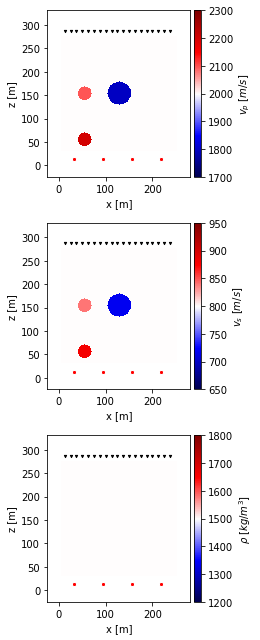

In [6]:
m = fd_model.get_model_vector()
fd_model.plot_model_vector(m, vmin=[1700, 650, 1200], vmax=[2300, 950, 1800])

## Create true data

In [7]:
for i_shot in range(fd_model.n_shots):
    fd_model.forward_simulate(i_shot, omp_threads_override=6)

ux_obs, uz_obs = fd_model.get_synthetic_data()

## Visualize true data

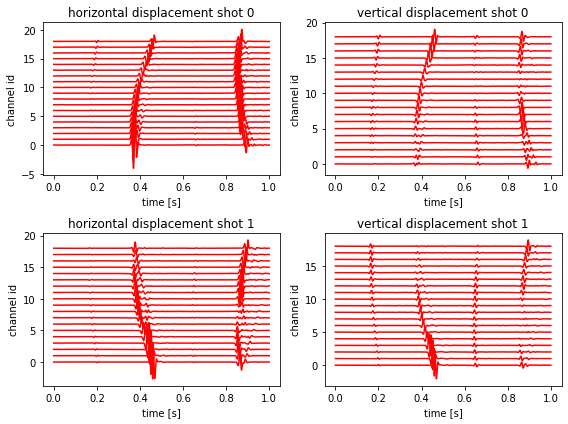

In [8]:
fd_model.plot_data((ux_obs, uz_obs))

## Visualize data difference with reference solution

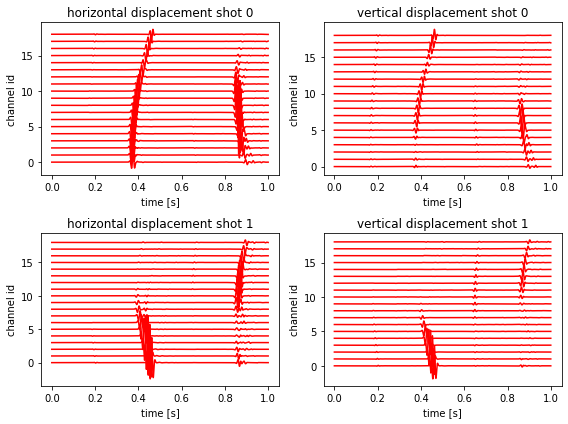

In [9]:
fd_model.plot_data((ux_obs - ux_ref, uz_obs - uz_ref))

## Save data and clear model

In [14]:
fd_model = None
numpy.save("ux_obs.npy", ux_obs)
numpy.save("uz_obs.npy", uz_obs)

# Entry point 2: Pre-MCMC descent
## Create inverse problem

In [16]:
ux_obs = numpy.load("ux_obs.npy")
uz_obs = numpy.load("uz_obs.npy")

distribution_1 = hmc_tomography.Distributions.psvWave(
    "conf_10k.ini", ux_obs=ux_obs, uz_obs=uz_obs, omp_threads_override=6
)

distribution_2 = hmc_tomography.Distributions.psvWave(distribution_1)

assumed_noise_level = 1.0

distribution_1.temperature = assumed_noise_level ** 2
distribution_2.temperature = assumed_noise_level ** 2

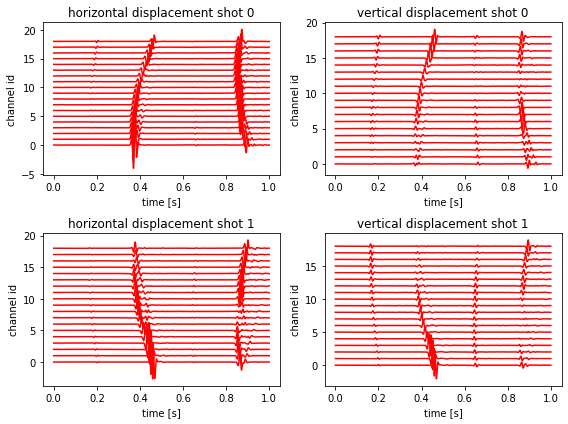

In [12]:
distribution_1.fdModel.plot_observed_data()

## Define priors

In [14]:
free_parameters_per_field = int(distribution_1.dimensions / 3)

standard_deviation = numpy.vstack(
    [
        numpy.ones((free_parameters_per_field, 1)) * 200,
        numpy.ones((free_parameters_per_field, 1)) * 50,
        numpy.ones((free_parameters_per_field, 1)) * 50,
    ]
)

scale = standard_deviation / (2 ** 0.5)

prior_1 = hmc_tomography.Distributions.Laplace(
    distribution_1.get_model_vector(), dispersions=scale
)

prior_2 = hmc_tomography.Distributions.Normal(
    distribution_2.get_model_vector(), covariance=standard_deviation * 2
)

/home/larsgebraad/Documents/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Distributions/base.py:392: Warning: Seems that you only passed a vector as the covariance matrix. It will be used as the covariance diagonal.
  Warning,


## Apply Bayes' rule

In [15]:
posterior_1 = hmc_tomography.Distributions.BayesRule([prior_1, distribution_1])
posterior_2 = hmc_tomography.Distributions.BayesRule([prior_2, distribution_2])

## Wrap the functions to allow for SciPy

In [16]:
def misfit_1(m):
    return posterior_1.misfit(m[:, None])


def gradient_1(m):
    return posterior_1.gradient(m[:, None])[:, 0]


def misfit_2(m):
    return posterior_2.misfit(m[:, None])


def gradient_2(m):
    return posterior_2.gradient(m[:, None])[:, 0]

## Do L-BFGS gradient descent

In [18]:
options = {"ftol": 1e-4, "disp": True, "maxiter": 100, "maxcor": 20}

res_1 = minimize(
    misfit_1,
    distribution_1.get_model_vector() + 5,
    method="L-BFGS-B",
    jac=gradient_1,
    options=options,
)

distribution_1.set_model_vector(res_1.x[:, None])

res_2 = minimize(
    misfit_2,
    distribution_2.get_model_vector() + 5,
    method="L-BFGS-B",
    jac=gradient_2,
    options=options,
)

distribution_2.set_model_vector(res_2.x[:, None])

## Visual inspection of final models

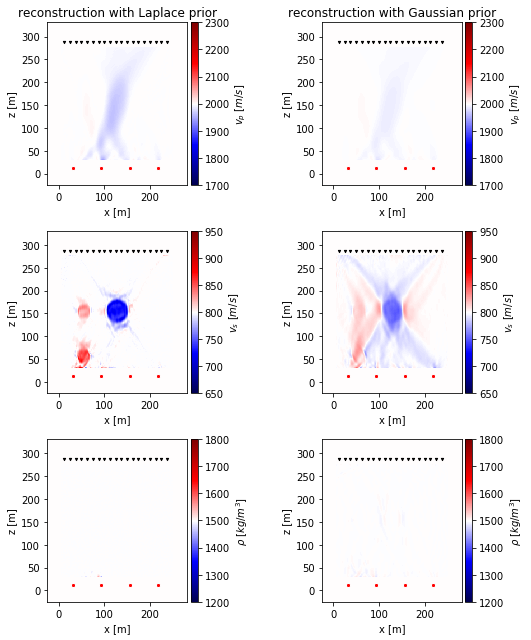

In [27]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 9))

axes[0, 0].set_title("reconstruction with Laplace prior")
axes[0, 1].set_title("reconstruction with Gaussian prior")

distribution_1.fdModel.plot_fields(
    axes=axes[:, 0], vmin=[1700, 650, 1200], vmax=[2300, 950, 1800]
)

distribution_2.fdModel.plot_fields(
    axes=axes[:, 1], vmin=[1700, 650, 1200], vmax=[2300, 950, 1800]
)

## Visualize distribution of final model parameters per group

NameError: name 'res_1' is not defined

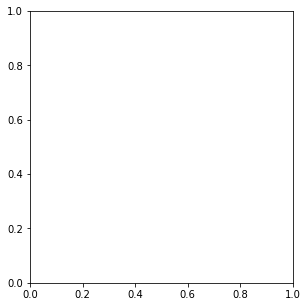

In [28]:
plt.figure(figsize=(16, 5))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    _ = plt.hist(res_1.x[int(10800 * i) : int(10800 * (i + 1))], bins=20, alpha=0.5, label="using Laplace prior")
    _ = plt.hist(res_2.x[int(10800 * i) : int(10800 * (i + 1))], bins=20, alpha=0.5, label="using Gaussia prior")
    plt.legend()

## Compute Hessian diagonals

This can take quite a while. On a 6-core i7 it takes 40 minutes per distribution for 120'000 parameters.

In [22]:
# Extracting the diagonal from the L-BFGS-B algorithm
diagonal1 = numpy.empty_like(res_1.x)

import tqdm

for i in tqdm.trange(res_1.x.size):
    basis = numpy.zeros_like(res_1.x)
    basis[i] = 1.0
    diagonal1[i] = res_1.hess_inv.matvec(basis)[i]

100%|██████████| 120000/120000 [39:06<00:00, 51.13it/s]


In [23]:
# Extracting the diagonal from the L-BFGS-B algorithm
diagonal2 = numpy.empty_like(res_2.x)

import tqdm

for i in tqdm.trange(res_2.x.size):
    basis = numpy.zeros_like(res_2.x)
    basis[i] = 1.0
    diagonal2[i] = res_2.hess_inv.matvec(basis)[i]

100%|██████████| 120000/120000 [38:28<00:00, 51.97it/s] 


## Save final model and diagonals of the Hessian

In [31]:
numpy.save("m1_lbfgs_100iter_cor20", distribution_1.get_model_vector())
numpy.save("m2_lbfgs_100iter_cor20", distribution_2.get_model_vector())
numpy.save("diagonal1", diagonal1)
numpy.save("diagonal2", diagonal2)
distribution_1 = None
distribution_2 = None
posterior_1 = None
posterior_2 = None

# Entry point 3: MCMC

In [2]:
import hmc_tomography
import numpy
import matplotlib.pyplot as plt

In [3]:
ux_obs = numpy.load("ux_obs.npy")
uz_obs = numpy.load("uz_obs.npy")

distribution_1 = hmc_tomography.Distributions.psvWave(
    "conf_10k.ini", ux_obs=ux_obs, uz_obs=uz_obs, omp_threads_override=6
)

distribution_2 = hmc_tomography.Distributions.psvWave(distribution_1)

assumed_noise_level = 1.0

distribution_1.temperature = assumed_noise_level ** 2
distribution_2.temperature = assumed_noise_level ** 2


distribution_1.set_model_vector(numpy.load("m1_lbfgs_100iter_cor20-1.7.npy"))
distribution_2.set_model_vector(numpy.load("m2_lbfgs_100iter_cor20-1.7.npy"))
diagonal1 = numpy.load("diagonal1.npy")
diagonal2 = numpy.load("diagonal2.npy")

In [4]:
free_parameters_per_field = int(distribution_1.dimensions / 3)

standard_deviation = numpy.vstack(
    [
        numpy.ones((free_parameters_per_field, 1)) * 200,
        numpy.ones((free_parameters_per_field, 1)) * 50,
        numpy.ones((free_parameters_per_field, 1)) * 50,
    ]
)

scale = standard_deviation / (2 ** 0.5)

prior_1 = hmc_tomography.Distributions.Laplace(
    distribution_1.get_model_vector(), dispersions=scale
)

prior_2 = hmc_tomography.Distributions.Normal(
    distribution_2.get_model_vector(), covariance=standard_deviation * 2
)

posterior_1 = hmc_tomography.Distributions.BayesRule([prior_1, distribution_1])
posterior_2 = hmc_tomography.Distributions.BayesRule([prior_2, distribution_2])

/home/larsgebraad/Documents/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Distributions/base.py:392: Warning: Seems that you only passed a vector as the covariance matrix. It will be used as the covariance diagonal.
  Warning,


In [5]:
std_from_lbfgs_1 = ((1.0 / (diagonal1 - 1)) ** 0.5)[:, None]
std_from_lbfgs_2 = ((1.0 / (diagonal2 - 1)) ** 0.5)[:, None]

/home/larsgebraad/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
/home/larsgebraad/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


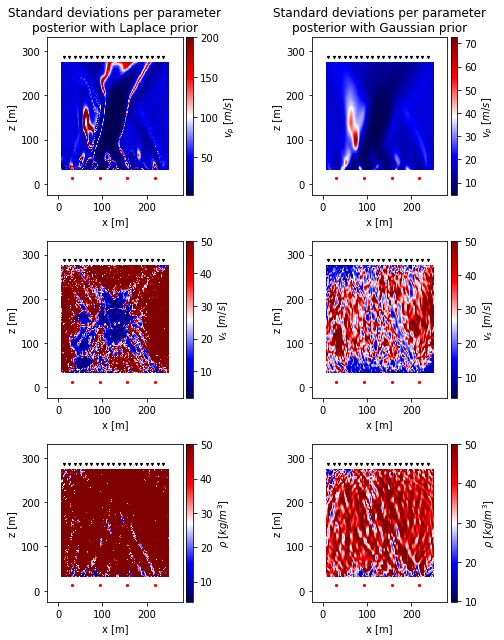

In [6]:
min_std_1 = numpy.nanmin(numpy.hstack([std_from_lbfgs_1, standard_deviation]), axis=1)
min_std_2 = numpy.nanmin(numpy.hstack([std_from_lbfgs_2, standard_deviation]), axis=1)

figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 9))


axes[0, 0].set_title("Standard deviations per parameter\nposterior with Laplace prior")
axes[0, 1].set_title("Standard deviations per parameter\nposterior with Gaussian prior")

distribution_1.fdModel.plot_model_vector(
    min_std_1, axes=axes[:, 0],
)
distribution_2.fdModel.plot_model_vector(
    min_std_2, axes=axes[:, 1],
)

In [7]:
sampler = hmc_tomography.Samplers.HMC()
mm_opt_1 = hmc_tomography.MassMatrices.Diagonal(1.0 / (min_std_1 ** 2.0))

In [15]:
m0 = numpy.load("m1_lbfgs_100iter_cor20-1.7.npy")
numpy.random.seed(0)
m0 += 20 * numpy.random.randn(*m0.shape)

sampler.sample(
    "samples_FWI_opt_1-alt-burn-in-2.h5",
    posterior_1,
    mass_matrix=mm_opt_1,
    initial_model=sampler.dsdscurrent_model,
    overwrite_existing_file=True,
    time_step=0.0001,
    ram_buffer_size=1,
    proposals=800,
)

sys:1: Warning: 
Silently overwriting samples file (samples_FWI_opt_1-alt-burn-in-2.h5) if it exists.



Rate: 1.5253954901403657
H: 116163.48276917345 H_new: 116163.06051545922
X: 56260.52992756859 X_new: 56260.24074410607
K: 59902.95284160487 K_new: 59902.81977135314




Rate: 1.0284849846772357
H: 116575.44217825615 H_new: 116575.4140914254
X: 56260.24074410607 X_new: 56242.46104875197
K: 60315.20143415008 K_new: 60332.953042673435




Rate: 0.37965223473390664
H: 116179.213998172 H_new: 116180.18249778904
X: 56242.46104875197 X_new: 56221.312577079094
K: 59936.75294942002 K_new: 59958.869920709934




Rate: 0.9064448889556348
H: 116271.19010993572 H_new: 116271.28833498177
X: 56242.46104875197 X_new: 56230.7236509013
K: 60028.72906118375 K_new: 60040.56468408047




Rate: 0.5953076355521059
H: 116309.65872650311 H_new: 116310.17740347562
X: 56230.7236509013 X_new: 56222.52988076766
K: 60078.93507560181 K_new: 60087.647522707965




Rate: 1.0066606254408585
H: 116117.39078231924 H_new: 116117.38414377776
X: 56230.7236509013 X_new: 56224.950315337024
K: 59886.66713141794 K_new: 59892.433828440735




Rate: 3.07650348553154
H: 116749.01621613099 H_new: 116747.89242241083
X: 56224.950315337024 X_new: 56212.756509437015
K: 60524.06590079396 K_new: 60535.13591297382




Rate: 0.9203349185786772
H: 115777.5111572746 H_new: 115777.59417490785
X: 56212.756509437015 X_new: 56200.96672211109
K: 59564.75464783758 K_new: 59576.62745279676




Rate: 0.9616543774695296
H: 116066.45281474844 H_new: 116066.49191491629
X: 56200.96672211109 X_new: 56195.607460841915
K: 59865.48609263735 K_new: 59870.88445407437




Rate: 0.776061755402397
H: 115826.06533924476 H_new: 115826.31886242502
X: 56195.607460841915 X_new: 56188.48765758732
K: 59630.457878402834 K_new: 59637.8312048377




Rate: 0.4433862431499658
H: 116297.71115297936 H_new: 116298.52446698747
X: 56195.607460841915 X_new: 56184.461837165996
K: 60102.10369213745 K_new: 60114.06262982147




Rate: 1.0680258571844043
H: 116530.47258168663 H_new: 116530.40676973553
X: 56195.607460841915 X_new: 56186.36206319515
K: 60334.86512084472 K_new: 60344.04470654038




Rate: 1.2757511194238775
H: 115850.31379036122 H_new: 115850.0702552428
X: 56186.36206319515 X_new: 56181.535846734136
K: 59663.95172716607 K_new: 59668.53440850866




Rate: 0.33527419480662896
H: 116130.44284260397 H_new: 116131.53564919395
X: 56181.535846734136 X_new: 56176.13224071558
K: 59948.90699586983 K_new: 59955.40340847836




Rate: 0.6271284606893641
H: 116244.53286468275 H_new: 116244.9994685606
X: 56176.13224071558 X_new: 56161.245632874925
K: 60068.40062396717 K_new: 60083.75383568568




Rate: 0.7003063381910719
H: 116242.50849989805 H_new: 116242.86473731173
X: 56161.245632874925 X_new: 56152.23330992539
K: 60081.26286702312 K_new: 60090.631427386346




Rate: 0.9784301472764807
H: 116599.43997931015 H_new: 116599.4617851924
X: 56161.245632874925 X_new: 56157.416523383145
K: 60438.19434643523 K_new: 60442.04526180926




Rate: 0.768223614451538
H: 116776.54165054968 H_new: 116776.80532497325
X: 56157.416523383145 X_new: 56148.64005932778
K: 60619.12512716654 K_new: 60628.165265645475




Rate: 0.6520728790760072
H: 116155.46125512848 H_new: 116155.88885407406
X: 56148.64005932778 X_new: 56139.22066570462
K: 60006.8211958007 K_new: 60016.66818836943




Rate: 1.5188229721476647
H: 116369.21722146965 H_new: 116368.79928579519
X: 56139.22066570462 X_new: 56133.27166822596
K: 60229.996555765036 K_new: 60235.52761756922




Rate: 2.046462692014179
H: 115684.55898421822 H_new: 115683.84287143158
X: 56133.27166822596 X_new: 56130.993988138434
K: 59551.28731599226 K_new: 59552.848883293154




Rate: 1.1743576065171804
H: 116182.46644117485 H_new: 116182.30571989462
X: 56130.993988138434 X_new: 56118.59462487607
K: 60051.47245303642 K_new: 60063.711095018545




Rate: 1.0048049367270022
H: 115901.83327375882 H_new: 115901.82848032896
X: 56118.59462487607 X_new: 56113.23197094434
K: 59783.238648882754 K_new: 59788.59650938462




Rate: 0.8785665260600473
H: 115937.97288008718 H_new: 115938.10234373453
X: 56113.23197094434 X_new: 56105.5007664215
K: 59824.74090914284 K_new: 59832.60157731303




Rate: 1.100937286764628
H: 115625.27120664073 H_new: 115625.17504474486
X: 56105.5007664215 X_new: 56100.80612888478
K: 59519.77044021922 K_new: 59524.36891586008




Rate: 0.824890335147065
H: 116036.65630759878 H_new: 116036.84881242736
X: 56100.80612888478 X_new: 56096.55161889005
K: 59935.850178714005 K_new: 59940.297193537306




Rate: 2.711611664459283
H: 115802.75812093774 H_new: 115801.76057776948
X: 56096.55161889005 X_new: 56090.85678818903
K: 59706.20650204769 K_new: 59710.903789580465




Rate: 0.7690309944079474
H: 116263.4262891357 H_new: 116263.68891314117
X: 56090.85678818903 X_new: 56082.13244269736
K: 60172.56950094668 K_new: 60181.55647044382



In [16]:
sampler.accepted_proposals

22

In [24]:
with hmc_tomography.Post.Samples("samples_conf_120k_burn_in_1_2.7.20.h5") as samples:
    numpy.save("final_model_bun", samples[:-1,399])

[[2034.75867668]
 [2009.04712906]
 [2018.68026038]
 ...
 [1550.79082686]
 [1499.43727846]
 [1504.26561596]]
